<a href="https://colab.research.google.com/github/ekyaaa/machine-learning-semester5-2025/blob/main/UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Ekya Muhammad Hasfi Fadlilurrahman <br>
Kelas: TI3H<br>
Absen: 09<br>
NIM: 2341720111<br>

# **Tugas 3 — Heart Disease Dataset**
Untuk absen 09


Dataset: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset <br>
Deskripsi: Dataset medis untuk melihat pengelompokan pasien berdasarkan fitur kesehatan seperti tekanan darah, kolesterol, umur, dan lain-lain. <br>
Langkah tambahan: <br>
    o	Tangani nilai kosong (jika ada).<br>
    o	Buat fitur gabungan seperti “CholAge = cholesterol × age”.

## Import Library

In [16]:
!pip install annoy

In [17]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing
**Jumlah sampel**: 1025 <br>
**Fitur dasar** (semua int & oldpeak float): age, sex, ср, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target <br>
**Fitur gabungan**: CholAge, BPAge, HeartRatePerAge, Chol_BP_Ratio

In [29]:
## Melihat kondisi data
df = pd.read_csv('/content/drive/MyDrive/ML_Dataset/heart.csv')

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [30]:
# Mengecek missing value & Jumlah sample
print(f'\nJumlah sampel: {len(df)}')
print('Missing Values')
df.isnull().sum()


Jumlah sampel: 1025
Missing Values


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [26]:
# Tangani missing values
df.fillna(df.mean(), inplace=True)

# Membuat fitur gabungan CholAge = cholestrole*age
df['CholAge'] = df['chol'] * df['age']

df['BPAge'] = df['trestbps'] * df['age']       # Tekanan darah × umur
df['HeartRatePerAge'] = df['thalach'] / df['age']  # Detak jantung maksimal / umur
df['Chol_BP_Ratio'] = df['chol'] / df['trestbps']  # Rasio kolesterol / BP

# Normalisasi data numerik
num_df = df.select_dtypes(include=['float64','int64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

## Clustering dengan KMeans & DBScan

In [27]:
# --- KMEANS ---
# Tentukan jumlah cluster, misal 2
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Menambahkan label KMeans ke DataFrame
df['KMeans_label'] = labels_kmeans

# --- DBSCAN ---
# eps = jarak maksimum antar titik, min_samples = jumlah titik minimum dalam cluster
dbscan = DBSCAN(eps=0.8, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Menambahkan label DBSCAN ke DataFrame
df['DBSCAN_label'] = labels_dbscan

# Evaluasi
print("KMeans Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))
print("DBSCAN Silhouette:", silhouette_score(X_scaled, labels_dbscan))
print("DBSCAN Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_dbscan))

KMeans Silhouette: 0.1635087461973986
KMeans Davies-Bouldin: 2.098092040526149
DBSCAN Silhouette: 0.041636515315414326
DBSCAN Davies-Bouldin: 0.7604850952147287


## Visualisasi hasil clustering

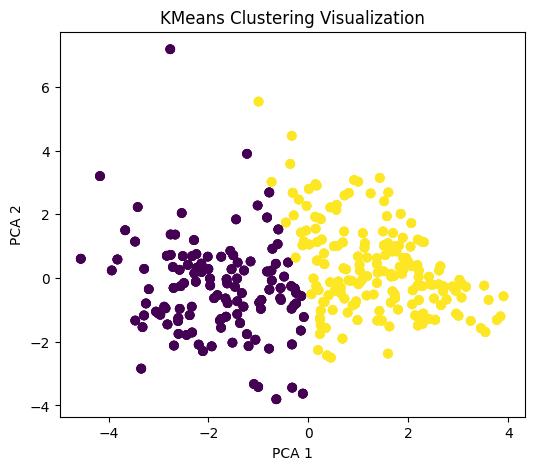

In [22]:
# Visualisasi Clustering 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

## ANN

In [25]:
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Tambahkan data
for i, x in enumerate(X_scaled):
    ann.add_item(i, x)

# Build index
ann.build(n_trees=10)

query_idx = min(42, X_scaled.shape[0]-1)

neighbors, distances = ann.get_nns_by_item(query_idx, 5, include_distances=True)

# Cetak hasil
print(f"Query Point Index: {query_idx}")
print("Nearest Neighbors and Distances:")
for n, d in zip(neighbors, distances):
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")

Query Point Index: 42
Nearest Neighbors and Distances:
Neighbor Index: 42 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 670 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 759 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 924 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 96 | Distance: 2.4744 | Cluster (KMeans): 1


### **Kesimpulan**
a. Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model ini dan jelaskan jawaban anda! <br>
Hasil menunjukkan perbedaan karakteristik antara KMeans dan DBSCAN. KMeans memiliki Silhouette 0.1635 dan Davies-Bouldin Index (DBI) 2.098, sedangkan DBSCAN memiliki Silhouette 0.0416 dan DBI 0.760. KMeans cenderung membentuk cluster yang lebih jelas dan koheren secara internal, meskipun DBSCAN lebih baik dalam hal jarak antar cluster. Secara keseluruhan, jika fokus pada kejelasan cluster, KMeans lebih baik, tetapi jika mempertimbangkan struktur data dan outlier, DBSCAN dapat lebih unggul, meskipun dalam kasus ini cluster DBSCAN kurang terdefinisi.
<br>

b.	Nilai metrik terbaik (Silhouette, DBI). <br>
Dari kedua model, nilai Silhouette terbaik dicapai oleh KMeans sebesar 0.1635, menunjukkan cluster yang lebih seragam secara internal. Sedangkan nilai DBI terbaik dicapai oleh DBSCAN sebesar 0.760, menandakan jarak antar cluster lebih baik dibanding KMeans. Hal ini menunjukkan bahwa metrik yang berbeda menilai aspek yang berbeda: Silhouette menekankan keseragaman dalam cluster, sedangkan DBI menilai pemisahan antar cluster.
<br>

c.	Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda. <br>
Hasil query Annoy untuk titik indeks 42 menunjukkan bahwa tetangga terdekat (42, 670, 759, 924) semuanya berada dalam cluster yang sama menurut KMeans. Bahkan tetangga yang lebih jauh (indeks 96) juga termasuk dalam cluster tersebut meskipun jaraknya lebih besar. Hal ini menunjukkan bahwa tetangga yang dekat secara jarak cenderung berada dalam cluster yang sama, sementara KMeans membentuk cluster dengan area yang relatif luas, sehingga beberapa titik jauh tetap masuk dalam cluster yang sama.